In [1]:
import json
import numpy as np
from shapely.geometry import shape, Point

with open('../../data/3. data_auxiliary/powiaty-max.geojson', "r", encoding="utf-8") as f:
     powiaty = json.load(f)

with open('../../data/3. data_auxiliary/wojewodztwa-max.geojson', "r", encoding="utf-8") as f:
     wojewodztwa = json.load(f)

### Read geojson data and compute powiat centroids

In [2]:
#some powiats share name across different voivodeships
def getVoivodeship(coords):
    point = Point(coords[0], coords[1])

    for feature in wojewodztwa['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            voivodeship = feature['properties']['nazwa']
    return voivodeship

In [3]:
def computeCentroids(gejsonData):
    n = len(gejsonData['features'])
    centroids = {}
    for i in range(n):
        powiat_name = gejsonData['features'][i]['properties']['nazwa']
        coords = np.array(gejsonData['features'][i]['geometry']['coordinates'][0][0])
        #compute the centroid
        a1 = coords[:-1,0]*coords[1:,1] - coords[1:,0]*coords[:-1,1]
        A = 0.5*sum(a1)
        Cx = 1/(6*A) * sum((coords[:-1,0] + coords[1:,0])*a1)
        Cy = 1/(6*A) * sum((coords[:-1,1] + coords[1:,1])*a1)
        #we need to join with voivodeship to get a unique key 
        voivodeship_name = getVoivodeship(np.mean(coords,axis=0))
        key = powiat_name + ', ' + voivodeship_name
        centroids[key] = [Cx, Cy]
    return centroids

In [4]:
centroids = computeCentroids(powiaty)

In [5]:
centroids_df = {'county': [], 'Voivodeship': [], 'Cx': [], 'Cy':[]}
for key, val in centroids.items():
    county, voivod = key.split(', ')
    voivod = 'województwo ' + voivod 
    centroids_df['county'].append(county)
    centroids_df['Voivodeship'].append(voivod)
    centroids_df['Cx'].append(val[0])
    centroids_df['Cy'].append(val[1])

In [6]:
import pandas as pd
df = pd.DataFrame(centroids_df)
df.head()
df.to_excel("../../data/3. data_auxiliary/powiat_centroids.xlsx", index=False)

### Plot centroids

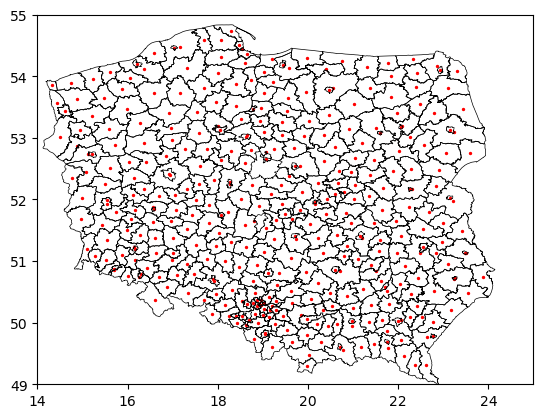

In [7]:
import matplotlib.pyplot as plt
npow = len(powiaty['features'])
for i in range(npow):
    a = np.array(powiaty['features'][i]['geometry']['coordinates'][0][0])
    plt.plot(a[:,0],a[:,1],'k',linewidth=0.5)
    plt.xlim([14, 25])
    plt.ylim([49,55])

for name, centre in centroids.items():
    plt.scatter(centroids[name][0], centroids[name][1],c='red',s=2)

In [8]:
wojewodztwa.clear()
powiaty.clear()

### Calculate distances between powiats and sort by distance

In [9]:
from haversine import haversine

In [10]:
powiat_proximity = {}
for powiat1, coords1 in centroids.items():
    if powiat1 not in powiat_proximity: 
        powiat_proximity[powiat1] = []
    for powiat2, coords2 in centroids.items():
        if powiat2 != powiat1:
            powiat_proximity[powiat1].append([powiat2, haversine(coords1[::-1], coords2[::-1])]) #haversine wants lat, lon, need to reverse coords

In [11]:
for powiat, neighbours in powiat_proximity.items():
    powiat_proximity[powiat] = sorted(neighbours, key=lambda x: x[1])

In [12]:
df = pd.DataFrame(powiat_proximity)
df.head()
df.to_excel("../../data/3. data_auxiliary/powiat_proximity.xlsx", index=False)